<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/2.model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [127]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [128]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [129]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [130]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [131]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils
import model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions
from sklearn_utils import print_model_cv_scores
from sklearn_utils import plot_cv_results
from sklearn_utils import fit_grid_search
from sklearn_utils import fit_randomized_search

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
from model import Model

# Fixing seed

In [132]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Setup paths (**Set preprocessing and model trials!**)

In [133]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 2
MODELS_TRIAL = 2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [134]:
manager = PathManager(
    competition_path=COMPETITION_PATH, 
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_2 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_2 already exists


# Download the data

In [135]:
kaggle_test_path = os.path.join(
    manager.data_trial_path,
    'test_processed.csv'
)
df_test = pd.read_csv(
    kaggle_test_path, index_col=[0]
)
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.995545,-1.032819,-0.285964,-0.26814,-0.383325,-0.807152,-0.633614,-0.182156,-0.619713,-0.217343,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,1.0,0.0,0.020451,0.693147
1,0.995545,-0.334236,-0.285964,-0.26814,-0.383325,0.014161,-0.633614,-0.182156,-1.176974,-0.790338,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,0.0,1.0,0.138344,0.693147


In [136]:
df_test_sample = pd.read_csv(
    os.path.join(manager.data_trial_path, 'test_sample_processed.csv'), 
    index_col=[0]
)
df_test_sample.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.994059,-1.032819,-1.653875,0.688913,-1.382555,-0.807152,-0.633614,-2.019553,-0.062452,-0.217343,...,-0.497002,-0.606797,-0.556056,-0.652386,0.0,0.0,1.0,0.0,0.071805,14.842280
1,0.993564,0.015056,0.397991,-0.268140,-1.382555,-0.807152,-0.159426,-0.182156,-0.062452,-0.217343,...,0.611695,0.655776,0.253599,0.511872,0.0,0.0,0.0,1.0,0.112946,15.312391


In [137]:
df_trainval = pd.read_csv(
    os.path.join(manager.data_trial_path, 'trainval_sample_processed.csv'), 
    index_col=[0]
)
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0.994554,-0.334236,-0.285964,-1.225193,-0.383325,0.014161,-0.633614,-0.182156,-0.062452,-0.217343,...,0.168216,0.655776,0.253599,1.094000,0.0,0.0,0.0,1.0,0.132383,15.278005
1,0.993564,-0.683527,-0.285964,-1.225193,0.615905,1.656785,0.788952,-0.182156,-0.619713,-0.790338,...,-0.497002,-0.606797,-0.556056,-0.652386,1.0,0.0,1.0,0.0,0.365242,15.255171


In [138]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [139]:
X_test_sample = df_test_sample.values[:, :-1]  # test subsample from training data
Y_test_sample = df_test_sample.values[:, -1]

# Select and train models (+ ensemble methods)

## Define models

In [ ]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {
            'n_estimators': [200, 500, 700],
            'max_depth': [5, 10, 15],
            'random_state': [42]
        }
    ],

    [
        {
            'n_estimators': [i * 100 for i in range(1, 11)],
            'max_depth': [i for i in range(1, 20)],
            'bootstrap': [True, False],
            'random_state': [42]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'ElasticNet',
    [
        {
            'alpha': [0.1, 0.3, 0.5],
            'l1_ratio': [0.2, 0.5],
            'random_state': [42]
        }, 
    ],
    [
        {
            'alpha': [i * 0.1 for i in range(1, 10)],
            'l1_ratio': [i * 0.1 for i in range(1, 10)],
            'random_state': [42]
        }
    ]
)

SVRModel = Model(
    SVR(),
    'SVM reg',
    [
        {
            'kernel': ['linear'],
            'C': [0.2, 0.5, 1.0]
        },
     
        {
            'kernel': ['rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.2, 0.5, 1.0]
        }
    ],
    [
        {
            'kernel': ['linear'],
            'C': [0.1 * i for i in range(1, 11)]
        },
        {
            'kernel': ['rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.1 * i for i in range(1, 11)]
        }
    ]
)

In [ ]:
XGBModel = Model(
    GradientBoostingRegressor(n_estimators=5),
    'XGB',
    [
        {
            'n_estimators': [3, 5, 7],
            'max_depth': [2, 4, 6, 8],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [42]
        }
    ],
    [
        {
            'n_estimators': [i for i in range(1, 9)],
            'max_depth': [i for i in range(1, 10)],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [42]
        }
    ]
)

pep8(_ih)

In [ ]:
all_models = {
    model.name: model for model in [
        # RFModel, 
        # SVRModel,
        ElasticNetModel,
        XGBModel
    ]
}

## Neural networks (if necessary)

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_val_ffnn = scaler.fit_transform(X_train_val)
X_test_ffnn = scaler.transform(X_test_sample)

X_train_ffnn, X_val_ffnn, Y_train_ffnn, Y_val_ffnn = train_test_split(
    X_train_val_ffnn,
    Y_train_val,
    train_size=0.8
)

X_train_ffnn.shape, X_val_ffnn.shape, Y_train_ffnn.shape, Y_val_ffnn.shape

((92, 43), (24, 43), (92,), (24,))

In [193]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


ffnn = Sequential(
    [
        layers.Input(X_train_val.shape[1]),
        # layers.Dense(15, activation='relu'),
        layers.Dense(15, activation='relu'),
        layers.Dense(1, activation='linear')
    ]
)

ffnn.compile(
    loss='mean_squared_error',
    optimizer='sgd'
)

In [194]:
from tensorflow.keras.callbacks import EarlyStopping 

stopper = EarlyStopping(
    mode='min',
    patience=3,
    monitor='val_loss'
)


history = ffnn.fit(
    X_train_ffnn,
    Y_train_ffnn,
    validation_data=(X_val_ffnn, Y_val_ffnn),
    batch_size = 16,
    epochs = 100,
    callbacks=[stopper]
)

Epoch 1/100
6/6 [==============================] - 0s 20ms/step - loss: 130.1700 - val_loss: 37.7027
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 12.4455 - val_loss: 5.4101
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 4.8618 - val_loss: 3.6342
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 4.5520 - val_loss: 3.5582
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 3.9126 - val_loss: 2.9212
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 3.0606 - val_loss: 3.3749
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 2.6086 - val_loss: 2.5327
Epoch 8/100
6/6 [==============================] - 0s 6ms/step - loss: 2.3305 - val_loss: 2.5240
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 1.9757 - val_loss: 2.0187
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 1.7538 - val_loss: 2.2693
Epoch 11/100
6/6 [======

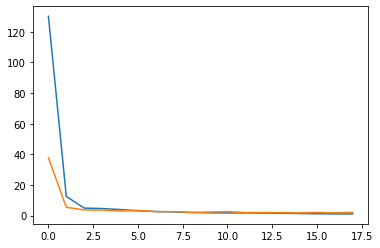

In [195]:
history.history.keys()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Preliminary look. Shortlisting 2-5 models, based on CV results, overfitting tendency

Model         Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
----------  ----------------------  ----------------  ------------------------  ------------------
ElasticNet               -0.231301         0.0163317                 -0.238785           0.102111
XGB                      -0.155301         0.0129419                 -0.209725           0.0918624


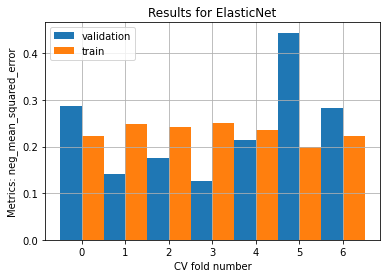

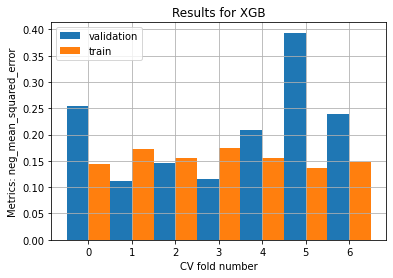

In [ ]:
# %%pycodestyle
np.random.seed(RANDOM_SEED)

res = plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

In [ ]:
shortlisted_models = {
    model.name: model for model in [
        # RFModel, 
        ElasticNetModel, 
        # SVRModel,
        XGBModel
    ]
}

# Fine tuning

## Grid search

In [ ]:
from sklearn_utils import dict_subset

rf_grid_search_results = fit_grid_search(
    dict_subset(shortlisted_models, ['RF']),
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

Fitting RF


In [ ]:
shortlisted_models.keys()

dict_keys(['RF', 'ElasticNet', 'SVM reg'])

In [ ]:
svm_grid_search_results = fit_grid_search(
    dict_subset(shortlisted_models, ['SVM reg']),
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

Fitting SVM reg


In [ ]:
elastic_grid_search_results = fit_grid_search(
    dict_subset(shortlisted_models, ['ElasticNet']),
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

Fitting ElasticNet


In [ ]:
grid_search_results = fit_grid_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

# grid_search_results = {
#     'RF': rf_grid_search_results['RF'],
#     'ElasticNet': elastic_grid_search_results['ElasticNet'],
#     'SVM reg': svm_grid_search_results['SVM reg']
# }

pep8(_ih)

Fitting ElasticNet
Fitting XGB



In [ ]:
grid_search_results['XGB'].best_estimator_

GradientBoostingRegressor(max_depth=4, max_features='auto', n_estimators=7,
                          random_state=42)

## Randomized search

In [ ]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=10,
    n_iter_=10,
    scoring_='neg_mean_squared_error'
)

Fitting ElasticNet
Fitting XGB


In [ ]:
# print(rand_search_results.get('RF').best_estimator_)
# print(rand_search_results['SVM reg'].best_estimator_)
rand_search_results['XGB'].best_estimator_

GradientBoostingRegressor(max_depth=5, max_features='sqrt', n_estimators=8,
                          random_state=42)

# Check final models for overfit

Model         Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
----------  ----------------------  ----------------  ------------------------  ------------------
ElasticNet               -0.198087        0.0117426                  -0.219998            0.121079
XGB                      -0.107611        0.00942798                 -0.197792            0.104977


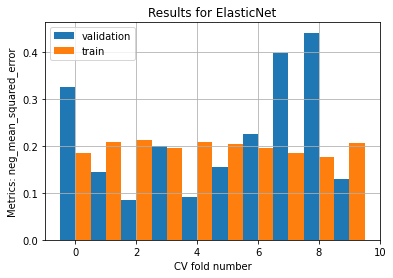

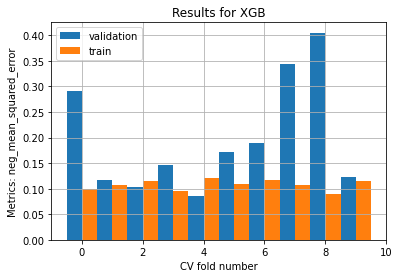

In [ ]:
_ = plot_cv_results(
    sklearn_models_dict_ = {
        model_name: result.best_estimator_
        for model_name, result in rand_search_results.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=10,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

Model         Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
----------  ----------------------  ----------------  ------------------------  ------------------
ElasticNet               -0.181866        0.0119854                  -0.215257            0.12174
XGB                      -0.112857        0.00899608                 -0.208708            0.103906


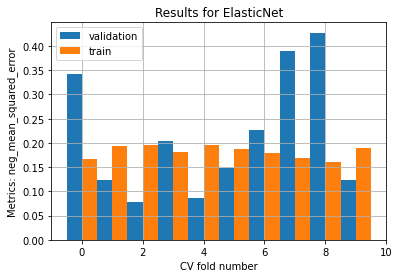

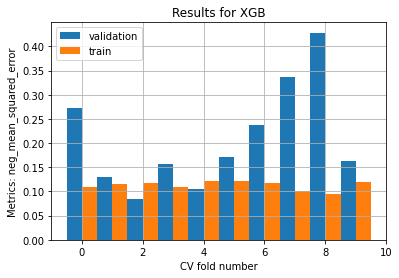

In [ ]:
_ = plot_cv_results(
    sklearn_models_dict_ = {
        model_name: result.best_estimator_
        for model_name, result in grid_search_results.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=10,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Saving fine tuned candidates (retrained on train+val subset)

In [ ]:
manager.save_models(
    {
        f'{model_name}_rand': result.best_estimator_
        for model_name, result in rand_search_results.items()
    }
)

manager.save_models(
    {
        f'{model_name}_grid_search': result.best_estimator_
        for model_name, result in grid_search_results.items()
    }
)

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_2/ElasticNet_rand already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_2/ElasticNet_grid_search already exists
